In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("./utils")

from utils.skseq.sequences.sequence import Sequence
from utils.skseq.readers import pos_corpus
from utils.skseq.sequences.id_feature import IDFeatures
from skseq.sequences.extended_feature import ExtendedFeatures
import utils.skseq.sequences.structured_perceptron as spc
from utils.hmm import HMM, evaluate_hmm
import tqdm
import csv

from utils.utils import *

### Reading the data

In [3]:
corpus = pos_corpus.PostagCorpus()

In [4]:
data_path = "data/"

train_seq = corpus.read_sequence_list(data_path + "train_data_ner.csv")                                     
test_seq = corpus.read_sequence_list(data_path + "test_data_ner.csv")

In [5]:
print(len(train_seq))
print(len(test_seq))

38358
38359


### Feature mapper

In [6]:
feature_mapper = IDFeatures(train_seq)

feature_mapper.feature_dict

{}

In [7]:
# get features
feature_mapper.build_features()

len(feature_mapper.feature_dict), len(feature_mapper.feature_list)

(39801, 38358)

In [8]:
# show some features
list(feature_mapper.feature_dict)[0:10]

['init_tag:O',
 'id:Thousands::O',
 'id:of::O',
 'prev_tag:O::O',
 'id:demonstrators::O',
 'id:have::O',
 'id:marched::O',
 'id:through::O',
 'id:London::B-geo',
 'prev_tag:O::B-geo']

### Load model 

In [9]:
models_path = 'fitted_models/'

sp = spc.StructuredPerceptron(corpus.word_dict, corpus.tag_dict, feature_mapper)
sp.load_model(models_path + "perceptron_15_iter")

In [10]:
sp.parameters

array([ 8.      ,  8.133333, 12.266667, ...,  2.2     , -3.533333,
        0.333333])

### Evaluation (accuracy, f1 weighted score)

In [13]:
# Make predictions for the various sequences using the trained model.
pred_train = sp.viterbi_decode_corpus(train_seq)
pred_test  = sp.viterbi_decode_corpus(test_seq)

In [15]:
len(pred_train), len(pred_test)

(38358, 38359)

In [11]:
import pickle

#with open('pred_test', 'wb') as fp:
#    pickle.dump(pred_test, fp)

with open('predictions/pred_train', 'rb') as fp:
    pred_train = pickle.load(fp)
    
with open('predictions/pred_test', 'rb') as fp:
    pred_test = pickle.load(fp)

In [14]:
# Evaluate and print accuracies
eval_train = evaluate_corpus(train_seq.seq_list, pred_train)
eval_test = evaluate_corpus(test_seq.seq_list, pred_test)
print("SP -  Accuracy Train: %.3f Test: %.3f"%(eval_train, eval_test))

SP -  Accuracy Train: 0.966 Test: 0.886


In [28]:
sp.state_labels

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-tim': 3,
 'B-org': 4,
 'I-geo': 5,
 'B-per': 6,
 'I-per': 7,
 'I-org': 8,
 'B-art': 9,
 'I-art': 10,
 'I-tim': 11,
 'I-gpe': 12,
 'B-nat': 13,
 'I-nat': 14,
 'B-eve': 15,
 'I-eve': 16}

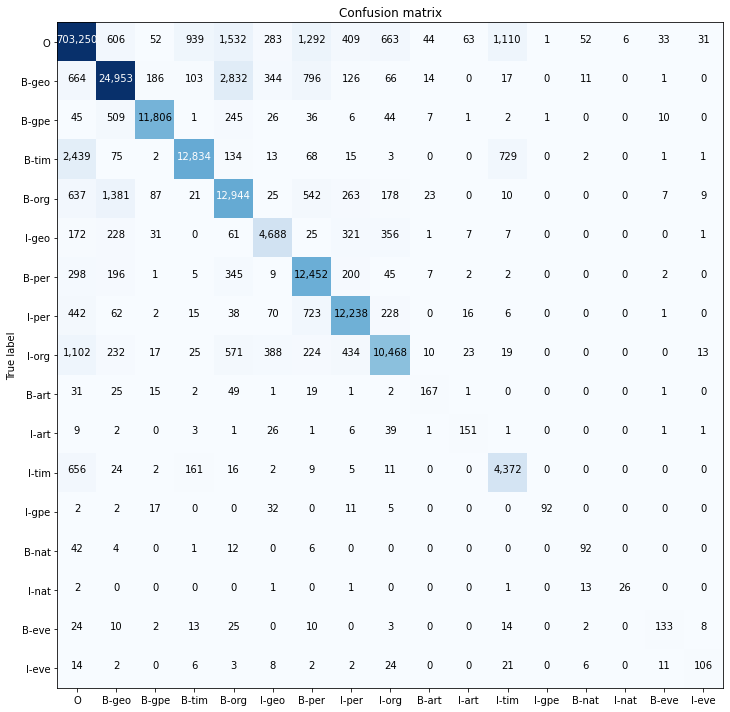

In [83]:
show_confusion_matrix(train_seq.seq_list, pred_train)

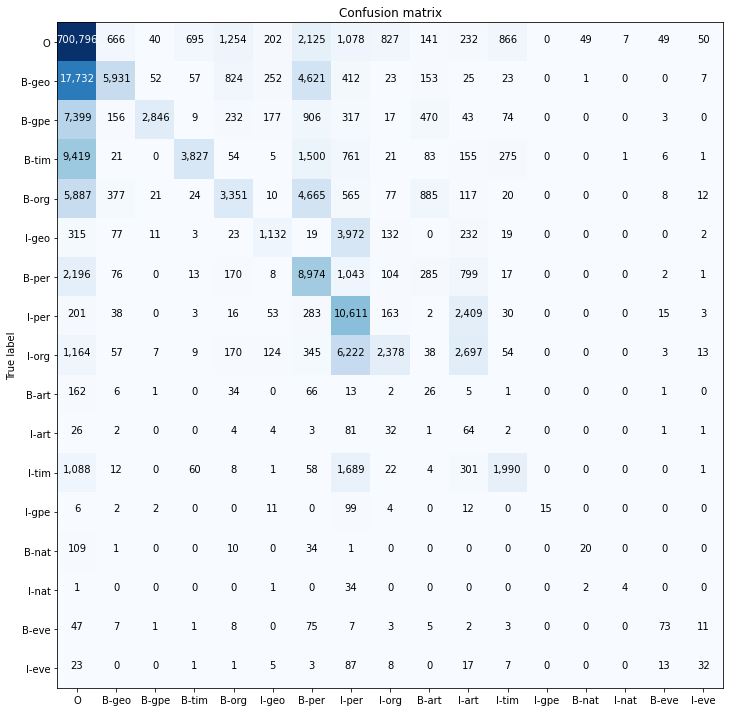

In [84]:
show_confusion_matrix(test_seq.seq_list, pred_test)

In [66]:
get_f1_score(train_seq.seq_list, pred_train)

0.9664978543456326

In [85]:
get_f1_score(test_seq.seq_list, pred_test)

0.8711365608527891

### Extended features

In [88]:
feature_mapper = ExtendedFeatures(train_seq)
feature_mapper.feature_dict

{}

In [89]:
# get features
feature_mapper.build_features()

len(feature_mapper.feature_dict), len(feature_mapper.feature_list)

(54291, 38358)

In [90]:
sp = spc.StructuredPerceptron(corpus.word_dict, corpus.tag_dict, feature_mapper)
sp.load_model(models_path + "perceptron_10_iter_extended")

In [91]:
sp.parameters

array([ 11.      ,   4.5     ,   2.583333, ..., -10.5     ,   1.416667,
         1.416667])

### Evaluation (accuracy, f1 weighted score)

In [92]:
# Make predictions for the various sequences using the trained model.
pred_train = sp.viterbi_decode_corpus(train_seq)
pred_test  = sp.viterbi_decode_corpus(test_seq)

100%|████████████████████████████████████| 38359/38359 [07:13<00:00, 88.50it/s]


In [93]:
len(pred_train), len(pred_test)

(38358, 38359)

In [94]:
import pickle

with open('predictions/pred_test_extended', 'wb') as fp:
    pickle.dump(pred_test, fp)
    
with open('predictions/pred_train_extended', 'wb') as fp:
    pickle.dump(pred_train, fp)

#with open('pred_train', 'rb') as fp:
#    pred_train = pickle.load(fp)
    
#with open('pred_test', 'rb') as fp:
#    pred_test = pickle.load(fp)

In [95]:
# Evaluate and print accuracies
eval_train = evaluate_corpus(train_seq.seq_list, pred_train)
eval_test = evaluate_corpus(test_seq.seq_list, pred_test)
print("SP -  Accuracy Train: %.3f Test: %.3f"%(eval_train, eval_test))

SP -  Accuracy Train: 0.961 Test: 0.898


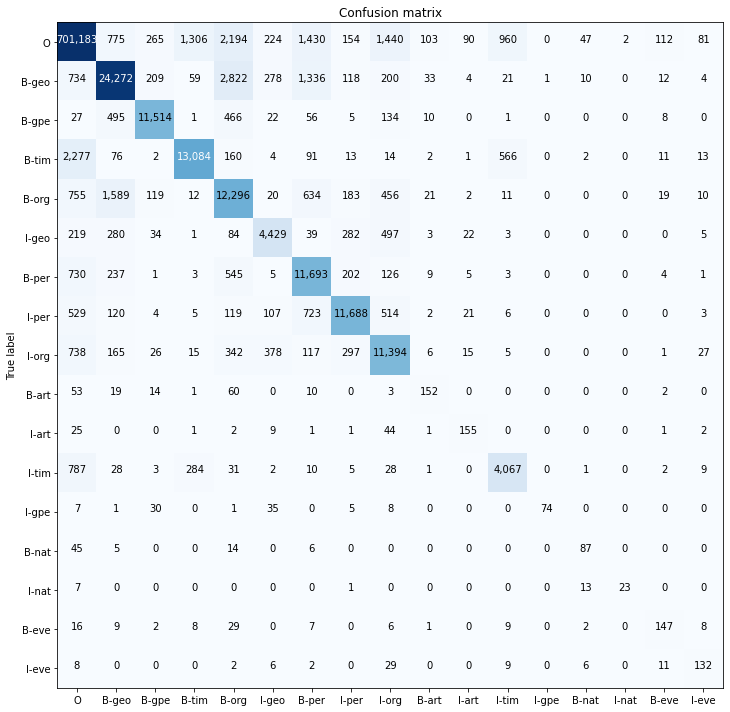

In [97]:
show_confusion_matrix(train_seq.seq_list, pred_train)

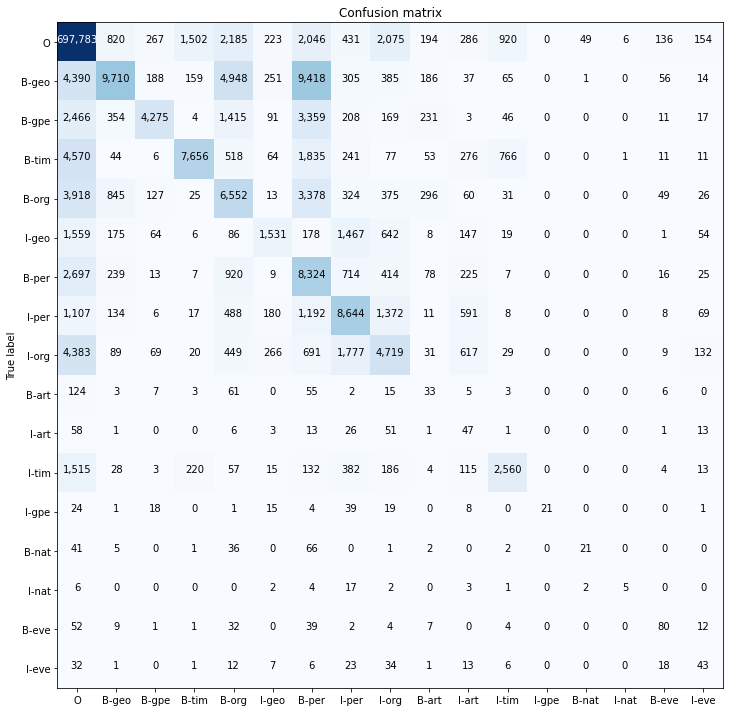

In [98]:
show_confusion_matrix(test_seq.seq_list, pred_test)

In [99]:
get_f1_score(train_seq.seq_list, pred_train)

0.961657257140306

In [100]:
get_f1_score(test_seq.seq_list, pred_test)

0.8953454569136883

### HMM 

In this section we check the results for an HMM with posterior decoding. The interest of such a model is that, being generative, it cannot take OOV words into account, so it serves to illustrate the advantage of the structured perceptron and other discriminative approaches.

The class and required functions for the HMM are in **utils/hmm.py**.

As recommended, we include the computation of the predictions for train (1h) and test (30min) in this notebook, and not in **train_models.ipynb**. Since fitting the model takes only 2 seconds, we have decided to include that step here as well, rather than fitting in **train_models.ipynb**, saving the class instance and loading it here (which is less practical in this case).

Mapping words and states to positions:

In [5]:
ind_to_word  = {v: k for k, v in train_seq.x_dict.items()}
ind_to_state = {v: k for k, v in train_seq.y_dict.items()}
word_to_ind  = train_seq.x_dict
state_to_ind = train_seq.y_dict

Train values:

In [6]:
X = []
Y = []
for i in range(len(train_seq)):
    xy = train_seq[i]
    X.append([ind_to_word[x_i] for x_i in xy.x])
    Y.append([ind_to_state[y_i] for y_i in xy.y])

Test values:

In [7]:
X_test = []
Y_test = []
for i in range(len(test_seq)):
    xy = test_seq[i]
    X_test.append([ind_to_word[x_i] for x_i in xy.x])
    Y_test.append([ind_to_state[y_i] for y_i in xy.y])

Now we fit our HMM:

In [8]:
hmm = HMM(word_to_ind, state_to_ind)
hmm.fit(X, Y)

/home/bambusito/Desktop/backup/Dropbox/masterBCN/NLP/Assignments/NLP-NER/utils/hmm.py:168: RuntimeWarning: divide by zero encountered in log
  return {"emission":   np.log(probs["emission"]),
/home/bambusito/Desktop/backup/Dropbox/masterBCN/NLP/Assignments/NLP-NER/utils/hmm.py:169: RuntimeWarning: divide by zero encountered in log
  "transition": np.log(probs["transition"]),
/home/bambusito/Desktop/backup/Dropbox/masterBCN/NLP/Assignments/NLP-NER/utils/hmm.py:170: RuntimeWarning: divide by zero encountered in log
  "final":      np.log(probs["final"]),
/home/bambusito/Desktop/backup/Dropbox/masterBCN/NLP/Assignments/NLP-NER/utils/hmm.py:171: RuntimeWarning: divide by zero encountered in log
  "initial":    np.log(probs["initial"])}


Predictions are easily drawn:

In [23]:
y_hat = hmm.predict_labels(X[0])

In [24]:
y_hat[10:15], Y[0][10:15]

(['O', 'O', 'B-geo', 'O', 'O'], ['O', 'O', 'B-geo', 'O', 'O'])

Let us now go fot the whole train and test datasets. They take us a while (roughly 1h and 30min), so we saved the predictions (see below) in case you don't want to rerun them:

In [23]:
Y_hat = []
for x in tqdm.tqdm(X):
    Y_hat.append(hmm.predict_labels(x))

100%|██████████| 38358/38358 [54:05<00:00, 11.82it/s]  


In [19]:
Y_test_hat = []
for x in tqdm.tqdm(X_test):
    Y_test_hat.append(hmm.predict_labels(x))

100%|██████████| 38359/38359 [30:48<00:00, 20.75it/s] 


Save train and test predictions:

In [16]:
# save preds to csv
fname = 'predictions/hmm_pred_train.csv'
with open(fname, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(Y_hat)
    
fname = 'predictions/hmm_pred_test.csv'
with open(fname, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(Y_test_hat)

Load predictions:

In [45]:
# read csv files as nested lists
fname = 'predictions/hmm_pred_train.csv'
with open(fname, 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = csv.reader(read_obj)
    # Pass reader object to list() to get a list of lists
    Y_hat = list(csv_reader)
    
fname = 'predictions/hmm_pred_test.csv'
with open(fname, 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = csv.reader(read_obj)
    # Pass reader object to list() to get a list of lists
    Y_test_hat = list(csv_reader)

Evaluation. Get accuracies (without counting true "O"s -outside-):

In [46]:
evaluate_hmm(Y, Y_hat, ignore_O=True)
evaluate_hmm(Y_test, Y_test_hat, ignore_O=True)

Accuracy of posterior decode ignoring 'O' tags: 0.8625698063674281
Accuracy of posterior decode ignoring 'O' tags: 0.14491939823588593


Very low test accuracy!

Confusion matrices:

In [ ]:
pos = list(state_to_ind.values())
labs = list(state_to_ind.keys())

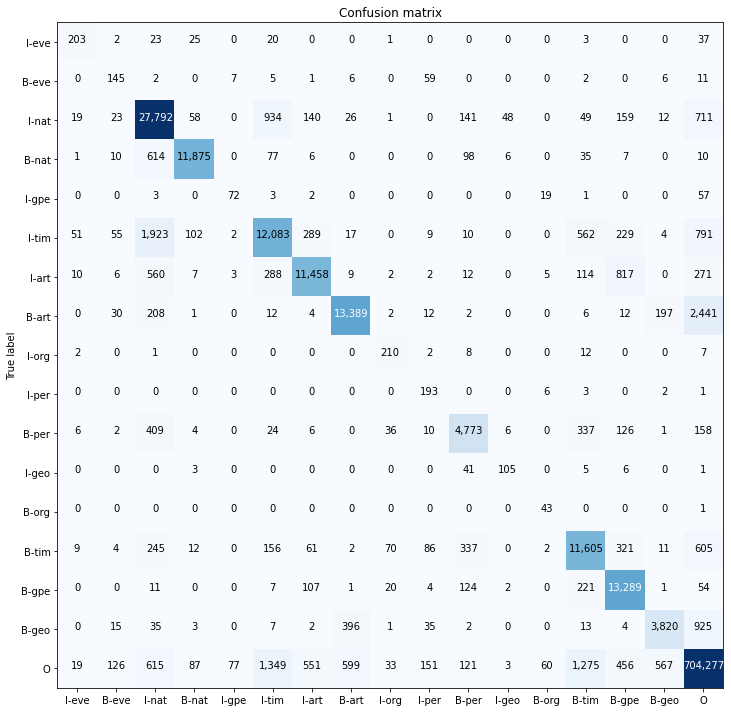

In [32]:
show_confusion_matrix(Y, Y_hat, positions=pos, labels=labs[::-1])

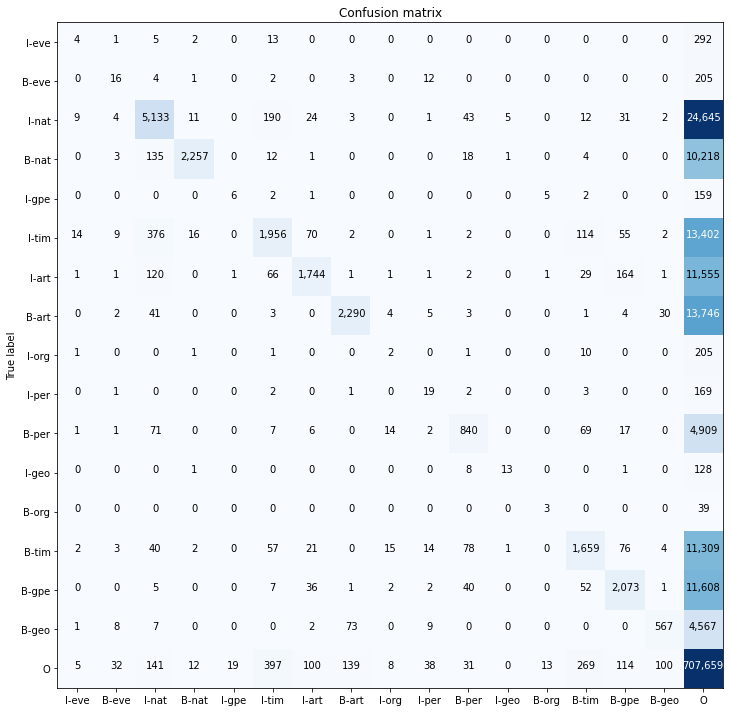

In [44]:
show_confusion_matrix(Y_test, Y_test_hat, positions=pos, labels=labs[::-1])

Something's off with the axes of the confusion matrix, at least in test: counts don't correspond to true values (only for "O"):

In [41]:
tag_counts = {}

for i, seq  in enumerate(Y_test):
    for j, t in enumerate(seq):
        tag_counts[t] = tag_counts.get(t, 0) + 1

tag_counts

{'B-gpe': 12649,
 'O': 709077,
 'B-tim': 16129,
 'B-org': 16019,
 'B-geo': 30113,
 'B-per': 13688,
 'I-per': 13827,
 'I-tim': 5234,
 'B-art': 317,
 'I-geo': 5937,
 'B-nat': 175,
 'I-org': 13281,
 'I-nat': 42,
 'B-eve': 243,
 'I-art': 221,
 'I-eve': 197,
 'I-gpe': 151}

The confusion matrix for test reveals that most words are being tagged "O".  

Weighted f-scores:

In [19]:
get_f1_score(Y, Y_hat)

0.9716972078527034

In [20]:
get_f1_score(Y_test, Y_test_hat)

0.8242359472031215

Why is the HMM performing so bad at test? Because of OOV words. If we look at accuracies taking also the true "O"'s into account, we see a dramatic increase in test performance:

In [22]:
evaluate_hmm(Y, Y_hat, ignore_O=False)
evaluate_hmm(Y_test, Y_test_hat, ignore_O=False)

Accuracy of posterior decode counting 'O' tags: 0.9716570434326641
Accuracy of posterior decode counting 'O' tags: 0.8673605637167084


This, together with the result for the confusion matrix, tells us what has happened: at test, most words are tagged "O". Since there are many OOV words in test, they will be likely to be assigned the most frequent tag at train ("O", 85% of total counts). As the test dataset is also mostly "O"s (85% as well), the effect of false "O"s is little when considering all tags, but when barring out uninteresting tags we get the false "O"s as errors without getting the true ones as right, giving the very low accuracy of 0.14.

That is why it is important to properly account for OOV words!